# Read cleaned Input files

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
import json
get_ipython().run_line_magic('matplotlib', 'inline')

# read in the json files
portfolio = pd.read_json('data/portfolio_clean.json', orient='records', lines=True)
profile = pd.read_json('data/new_profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript_profile_merge.json', orient='records', lines=True)

# Data Exploration & Visualization

In [2]:
profile[['income','age','days_being_members']].describe()

income           age  days_being_members
count   14825.000000  14825.000000        14825.000000
mean    65404.991568     54.393524         1783.478988
std     21598.299410     17.383705          419.205158
min     30000.000000     18.000000         1261.000000
25%     49000.000000     42.000000         1469.000000
50%     64000.000000     55.000000         1619.000000
75%     80000.000000     66.000000         2058.000000
max    120000.000000    101.000000         3084.000000

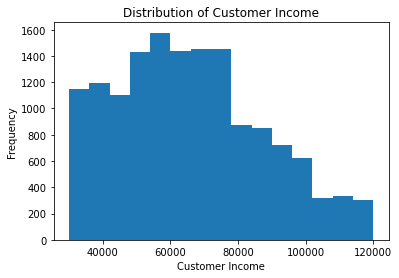

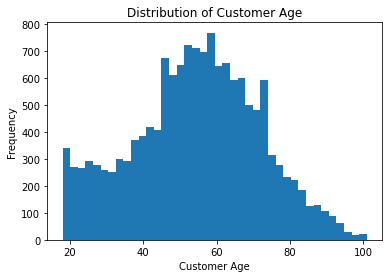

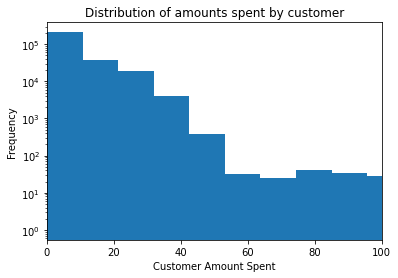

In [3]:
def plot_customer_data():
    '''Plot customer income and age data'''
    
    # Plot histogram of user income
    customer_income = profile['income'].plot(kind='hist', bins=15, title='Distribution of Customer Income')
    customer_income.set_xlabel("Customer Income")
    plt.savefig('img/Distribution_of_Customer_Income.png')
    # Plot histogram of customer age
    plt.figure()
    customer_age = profile['age'].plot(kind='hist', bins=40, title='Distribution of Customer Age')
    customer_age.set_xlabel("Customer Age")
    plt.savefig('img/Distribution_of_Customer_Age.png')
    plt.figure()
    costumer_amount = transcript['amount'].plot(kind='hist', bins=100,logy=True,xlim=(0,100),title='Distribution of amounts spent by customer');
    costumer_amount.set_xlabel("Customer Amount Spent")
    plt.savefig('img/Distribution_of_amounts_spent_by_customer.png')
    
plot_customer_data()

* Sample mean age is 54 years. Sample has a relatively normal distribuion.
* Sample Mean income is arround 65000. 
* The mayority of the transactions done in Starbucks are between 0 and 30.

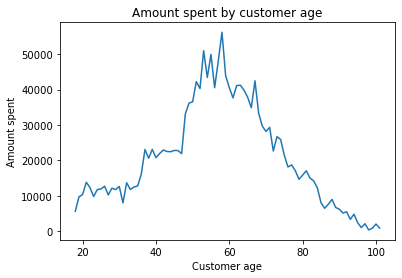

In [4]:
amount_age = transcript.groupby(['age']).agg('sum')['amount'].plot(title='Amount spent by customer age')
amount_age.set_xlabel("Customer age")
amount_age.set_ylabel("Amount spent")
plt.savefig('img/Amount_spent_by_customer_age.png')

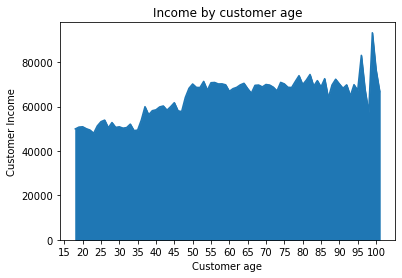

In [5]:
amount_age = transcript.groupby(['age']).agg('mean')['income'].plot.area(xticks=(np.arange(15,105,5)),title='Income by customer age')
amount_age.set_xlabel("Customer age")
amount_age.set_ylabel("Customer Income")
plt.savefig('img/Income_by_customer_age.png')

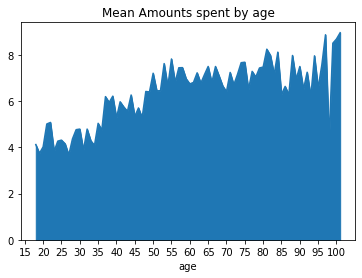

In [6]:
age_amount = transcript.groupby(['age'])['amount'].agg('mean')
age_amount.plot.area(xticks=(np.arange(15,105,5)),title='Mean Amounts spent by age');
plt.savefig('img/Mean_Amounts_spent_by_age.png')

* Ammount spent seems to be proportional to the age (higher the age, higher the mean ammount spent) 

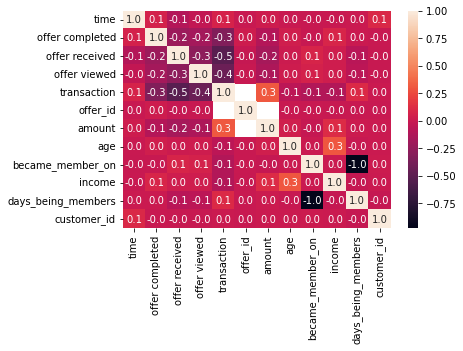

In [7]:
import seaborn as sns 
sns.heatmap(transcript.corr(),annot=True,fmt='.1f'); # see the correlation of each qualitative variable

* No strong correlation is seen between parameters

In [8]:
transcript.head()

event  time  offer completed  offer received  offer viewed  \
0   offer received     0                0               1             0   
1     offer viewed     6                0               0             1   
2      transaction   132                0               0             0   
3  offer completed   132                1               0             0   
4      transaction   144                0               0             0   

   transaction  offer_id  amount gender  age  became_member_on  income  \
0            0       3.0    0.00      F   75          20170509  100000   
1            0       3.0    0.00      F   75          20170509  100000   
2            1       NaN   19.89      F   75          20170509  100000   
3            0       3.0    0.00      F   75          20170509  100000   
4            1       NaN   17.78      F   75          20170509  100000   

   days_being_members  customer_id  
0                1704            1  
1                1704            1  
2                1704            1  
3                1704            1  
4                1704            1

# Recomendation Engine

In [9]:
def create_costumer_matrix(offer_customer, filename):
    '''
    Return the costumer matrix that indicate the number of offer completed of each user
    
    Inputs:
    offer - a cleaned transcript dataframe
    filename [string] - the file name that save the costumer_matrix
    
    Output:
    user_item_matrix - the costumer_matrix 
        - row = customer 
        - column = offer
        - value is the number of offer completed by the user 
            - NaN means no offer given to this customer
    
    '''
    # create an empty matrix with nan values
    costumer_matrix = offer_customer.groupby(['customer_id', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # drop informational offer type
    costumer_matrix.drop(list(portfolio[portfolio['offer_type']=='informational'].index), axis=1, inplace=True)
    
    for offer_id in costumer_matrix.columns:
        print("Offer id: %i"  %(offer_id))
        for customer in costumer_matrix.index:
            events = []
            for event in offer_customer[(offer_customer['offer_id']==offer_id) & (offer_customer['customer_id']==customer)]['event']:
                events.append(event)
            if len(events) >= 3:
                costumer_matrix.loc[customer, offer_id] = 0
                for i in range(len(events) - 2):
                    # If teh sequence is offer recieved -> offer viewed -> offer completed, this will mean that the offer was usefull
                    # Transaction is not used since its not linked with the offers
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        costumer_matrix.loc[customer, offer_id] += 1
            elif len(events) > 0:
                costumer_matrix.loc[customer, offer_id] = 0
    
    # store the martix into pickle file
    fh = open(filename, 'wb')
    pickle.dump(costumer_matrix,fh)
    fh.close()
    print("Done")
    
    return costumer_matrix

In [10]:
full_offer_customer = transcript[['event', 'customer_id','offer_id','time']].sort_values('time')
# Divide into Train and Test DF
train_offer_customer = full_offer_customer[:int(full_offer_customer.shape[0]*0.7)]
test_offer_customer = full_offer_customer[int(full_offer_customer.shape[0]*0.7):]

In [11]:
full_customer_matrix = create_costumer_matrix(full_offer_customer, 'full_customer_matrix.p')
train_customer_matrix = create_costumer_matrix(train_offer_customer, 'train_customer_matrix.p')
test_customer_matrix = create_costumer_matrix(test_offer_customer, 'test_customer_matrix.p')

Offer id: 0
Offer id: 1
Offer id: 3
Offer id: 4
Offer id: 5
Offer id: 6
Offer id: 8
Offer id: 9
Done
Offer id: 0
Offer id: 1
Offer id: 3
Offer id: 4
Offer id: 5
Offer id: 6
Offer id: 8
Offer id: 9
Done
Offer id: 0
Offer id: 1
Offer id: 3
Offer id: 4
Offer id: 5
Offer id: 6
Offer id: 8
Offer id: 9
Done


In [63]:
def FunkSVD(full_mat, latent_features=5, learning_rate=0.0001, iters=250):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    Inputs:
    full_mat - [numpy array] a matrix with customers as rows, offers as columns, and offer completed as values
    latent_features - [int] the number of latent features used
    learning_rate - [float] the learning rate 
    iters - [int] the number of iterations
    
    Outputs:
    customer_mat - [numpy array] a customer by latent feature matrix
    offer_mat - [numpy array] a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_customer = full_mat.shape[0]
    n_offers = full_mat.shape[1]
    num_full = np.count_nonzero(~np.isnan(full_mat))
    
    # initialize the user and movie matrices with random values
    customer_mat = np.random.rand(n_customer, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Iteration  Acumulative Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each customer offer pair
        for i in range(n_customer):
            for j in range(n_offers):
                
                # if the rating exists
                if full_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the customer and offer latent features
                    diff = full_mat[i, j] - np.dot(customer_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        customer_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*customer_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_full))
        
    return customer_mat, offer_mat 

## Hyper Parameter 

In [59]:
accur = []
for lf in range(5,30,5):
    print('Mean square error for %i latent factor' %lf)
    train_customer_mat_lf, train_offer_mat_lf = FunkSVD(train_customer_matrix_np, latent_features=lf, learning_rate=0.005, iters=300)
    # Evaluation for latent features
    acurracy = validation_comparison(test_customer_matrix, train_customer_mat_lf, train_offer_mat_lf)
    accur.append(acurracy)

Mean square error for 5 latent factor
0.2919261404806285
Mean square error for 10 latent factor
0.3149760963513961
Mean square error for 15 latent factor
0.30171923222383207
Mean square error for 20 latent factor
0.3043782739321955
Mean square error for 25 latent factor
0.30579056616774947


Text(0, 0.5, 'Accuracy')

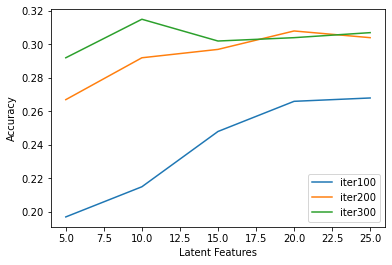

In [62]:
x100 = [5,10,15,20,25]
y100 = [0.197,0.215,0.248,0.266,0.268]
y200 = [0.267,0.292,0.297,0.308,0.304]
y300 = [0.292,0.315,0.302,0.304,0.307] 
plt.plot(x100,y100, label='iter100');
plt.plot(x100,y200, label='iter200');
plt.plot(x100,y300, label='iter300');
plt.legend()
plt.xlabel('Latent Features')
plt.ylabel('Accuracy')

In [64]:
# Create user-by-item matrix - nothing to do here
full_customer_matrix_np = np.array(full_customer_matrix)
train_customer_matrix_np = np.array(train_customer_matrix)
# Fit FunkSVD with the specified hyper parameters to the training data
#full_customer_mat, full_offer_mat = FunkSVD(full_customer_matrix_np, latent_features=15, learning_rate=0.005, iters=200)
train_customer_mat, train_offer_mat = FunkSVD(train_customer_matrix_np, latent_features=10, learning_rate=0.005, iters=300)

Iteration  Acumulative Mean Squared Error 
1 		 0.277722
2 		 0.244253
3 		 0.243950
4 		 0.243643
5 		 0.243335
6 		 0.243025
7 		 0.242712
8 		 0.242397
9 		 0.242079
10 		 0.241759
11 		 0.241436
12 		 0.241109
13 		 0.240780
14 		 0.240447
15 		 0.240110
16 		 0.239769
17 		 0.239425
18 		 0.239075
19 		 0.238722
20 		 0.238363
21 		 0.237999
22 		 0.237629
23 		 0.237254
24 		 0.236872
25 		 0.236484
26 		 0.236088
27 		 0.235685
28 		 0.235275
29 		 0.234855
30 		 0.234427
31 		 0.233990
32 		 0.233542
33 		 0.233084
34 		 0.232615
35 		 0.232134
36 		 0.231640
37 		 0.231133
38 		 0.230612
39 		 0.230076
40 		 0.229525
41 		 0.228957
42 		 0.228371
43 		 0.227767
44 		 0.227144
45 		 0.226500
46 		 0.225835
47 		 0.225146
48 		 0.224435
49 		 0.223698
50 		 0.222934
51 		 0.222143
52 		 0.221323
53 		 0.220473
54 		 0.219591
55 		 0.218676
56 		 0.217727
57 		 0.216741
58 		 0.215717
59 		 0.214655
60 		 0.213552
61 		 0.212407
62 		 0.211218
63 		 0.209984
64 		 0.208704
65 		 

## Validate Recomendation Model

In [65]:
def cutomer_reaction_pred(customer_matrix,offer_matrix,customer_id,offer_id):
    ''' predict how customers will react to an offer'''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        customer_ids_series = np.array(train_customer_matrix.index)
        offer_ids_series = np.array(train_customer_matrix.columns)
        # Customer row and offer Column
        customer_row = np.where(customer_ids_series == customer_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]
        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(customer_matrix[customer_row, :], offer_matrix[:, offer_col])
        return pred
    except:
        # Customer does not exist in our data, predictions can't be done        
        return None

def print_prediction_summary(customer_id, offer_id, prediction,train_customer_matrix):
    '''
    Prints predicted data compared with actual data
    '''
    actual_val = train_customer_matrix[offer_id][customer_id]
    predicted_val = prediction
    print("For customer {} we predict a {} for offer {}.".format(customer_id, round(prediction, 2), str(offer_id)))
    print("For customer {} actual value is {} for offer {}.".format(customer_id, round(actual_val, 2), str(offer_id)))

# validate predicted value for customer_id 5 and offer id 8
pred_cust5_offer8 = cutomer_reaction_pred(train_customer_mat,train_offer_mat,5,8)
print_prediction_summary(5, 8, pred_cust5_offer8,test_customer_matrix)

For customer 5 we predict a 0.49 for offer 8.
For customer 5 actual value is 1.0 for offer 8.


In [66]:
def validation_comparison(test_customer_matrix, train_customer_mat, train_offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_customer_matrix))
    
    sse_accum = 0
    
    for customer_id in test_customer_matrix.index:
        for offer_id in test_customer_matrix.columns:
            if ~np.isnan(test_customer_matrix.loc[customer_id, offer_id]):
                predict_value = cutomer_reaction_pred(train_customer_mat, train_offer_mat, customer_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_customer_matrix.loc[customer_id, offer_id] - cutomer_reaction_pred(train_customer_mat, train_offer_mat, customer_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [67]:
# Evaluation for latent features of 15
validation_comparison(test_customer_matrix, train_customer_mat, train_offer_mat)

0.312589774679857


## Recomendations concernig the entire sample 
* Defined by the amount of revenue each offer provided. 

In [18]:
portfolio

reward  difficulty  duration     offer_type  \
0      10          10         7           bogo   
1      10          10         5           bogo   
2       0           0         4  informational   
3       5           5         7           bogo   
4       5          20        10       discount   
5       3           7         7       discount   
6       2          10        10       discount   
7       0           0         3  informational   
8       5           5         5           bogo   
9       2          10         7       discount   

                                 id  web  email  mobile  social  bogo  \
0  ae264e3637204a6fb9bb56bc8210ddfd    0      1       1       1     1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0    1      1       1       1     1   
2  3f207df678b143eea3cee63160fa8bed    1      1       1       0     0   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    1      1       1       0     1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    1      1       0       0     0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2    1      1       1       1     0   
6  fafdcd668e3743c1bb461111dcafc2a4    1      1       1       1     0   
7  5a8bc65990b245e5a138643cd4eb9837    0      1       1       1     0   
8  f19421c1d4aa40978ebb69ca19b0e20d    1      1       1       1     1   
9  2906b810c7d4411798c6938adc9daaa5    1      1       1       0     0   

   discount  informational  
0         0              0  
1         0              0  
2         0              1  
3         0              0  
4         1              0  
5         1              0  
6         1              0  
7         0              1  
8         0              0  
9         1              0

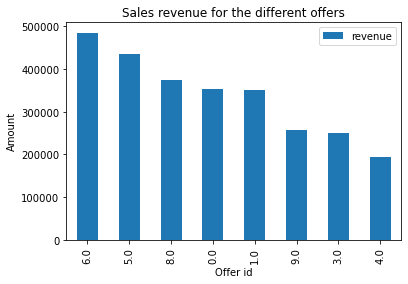

In [19]:
def best_offers(customer_matrix,plot=True):
    '''
    Find the offer that generates more revenew
    '''
    offer_gain = []
    for offer_id in customer_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['customer_id'].isin(list(customer_matrix[customer_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['amount'].sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'revenue'])
    offer_value['revenue'] = pd.to_numeric(offer_value['revenue'])
    offer_value.sort_values(by='revenue', ascending=False, inplace=True)
    if plot== True:
        best_sale = offer_value.plot('offer_id','revenue',kind='bar', title='Sales revenue for the different offers')
        best_sale.set_xlabel('Offer id')
        best_sale.set_ylabel('Amount')
    
    return offer_value
best_offer_revenue = best_offers(full_customer_matrix)

In [20]:
def gender_vs_offertype(full_customer_matrix):

    gender_df = transcript[['customer_id','gender']].groupby('customer_id').min()
    acummulative_gender = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['F', 'M', 'O'], columns=['bogo', 'discount'])
    offer_type_df=portfolio[['bogo','discount']]

    for customer_id in full_customer_matrix.index:
        row = full_customer_matrix.loc[customer_id]
        for offer_id in full_customer_matrix.columns:
            offer = row[offer_id]
            if offer>=1:
                if offer_type_df.loc[offer_id]['bogo']==1:
                    offer_type ='bogo' 
                elif offer_type_df.loc[offer_id]['discount']==1: 
                    offer_type ='discount'
                gen = gender_df.loc[customer_id]['gender']
                acummulative_gender.loc[gen][offer_type] += 1

        
    return acummulative_gender
g_vs_offer_abs = gender_vs_offertype(full_customer_matrix)

* Reaction of type of offer depending on the gender of the customer

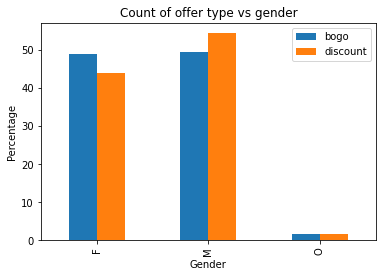

In [21]:
g_vs_offer_perc = g_vs_offer_abs/g_vs_offer_abs.sum() *100
g_vs_offer_plot = g_vs_offer_perc.plot(kind='bar',title='Count of offer type vs gender');
g_vs_offer_plot.set_xlabel("Gender");
g_vs_offer_plot.set_ylabel("Percentage");
plt.savefig('img/gender_offer_type.png')

## Recomendation for old and new customers
* Defined using the FunkSVD matrix defined earlier.

In [22]:
def recommend_offer(customer_id, train_customer_mat, train_offer_mat):
    recommendation = {}
    for offer_id in train_customer_matrix.columns:
        pred_val = cutomer_reaction_pred(train_customer_mat, train_offer_mat, customer_id, offer_id)
        if pred_val != None:
            recommendation[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("This customer is not in our database, recomended offers are the offers having the best sales.")
        top_offer = best_offers(full_customer_matrix,False)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("Recommend offer for customer ", customer_id)
        for offer_id, pred_val in sorted(recommendation.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " prediction: ", round(pred_val,2))



In [23]:
# recommend offer for a particular user
recommend_offer(15000, train_customer_mat, train_offer_mat)

This customer is not in our database, recomended offers are the offers having the best sales.
offer id:  6.0
offer id:  5.0
offer id:  8.0
offer id:  0.0
offer id:  1.0
offer id:  9.0
offer id:  3.0
offer id:  4.0


In [24]:
# recommend offer for a particular user
recommend_offer(3, train_customer_mat, train_offer_mat)

Recommend offer for customer  3
offer id:  5.0  prediction:  1.55
offer id:  8.0  prediction:  1.06
offer id:  3.0  prediction:  0.97
offer id:  9.0  prediction:  0.97
offer id:  4.0  prediction:  0.66
offer id:  0.0  prediction:  0.17
offer id:  1.0  prediction:  -0.05
offer id:  6.0  prediction:  -0.81
